# 1. Getting city outlines and hexbinning them

In this notebook, we will be using the Global Human Setllement Layer's [Urban Center Database](https://human-settlement.emergency.copernicus.eu/ghs_stat_ucdb2015mt_r2019a.php) to select which cities we will analyze. We will also divide the selected cities into hexagons using Uber's [H3 package](https://www.uber.com/en-BR/blog/h3/) for futher, hyperlocal analysis.

In [4]:
# Importing packages
import ee
import geemap
import geopandas as gpd
import h3
from os import makedirs
from os.path import exists
import numpy as np
import pandas as pd
from unidecode import unidecode
from shapely.geometry import Polygon

In [5]:
# Setting options
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1.1 Selecting urban centers

We are using the outlines of the urban centers as defined on this [research paper](https://www.nature.com/articles/s41597-023-02691-1), by scientists at the EU's Joint Research Center. It uses satellite observations to estimate population density at the entire Earth. Then, from this observations, it derives the extent of urban centers. 

The outline of cities _will not_ coindice with political-administrative divisions. Sometimes, one urban center may extend beyond national borders or connect cities that are often thought of as separate entities. However, as the article states, this approach is still best for international comparisons than relying on hard-to-compare, arbitrary administrative boundaries.

In [6]:
# Urban centers as defined by the EU Joint Research Center
cities = gpd.read_file("../data/GHS_STAT_UCDB2015MT_GLOBE_R2019A/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg")

In [4]:
# Gets rid of urban centers marked as 'false positives' and 'uncertain'
# This means that, while the satellite detected something there, experts disagreed about
# whether it should be classified as a city.
cities = cities[cities.QA2_1V==1]

In [5]:
# Applies unidecode on the city names to avoid errors 
# when saving files on Google Earth Engine later.
cities['UC_NM_LST'] = cities['UC_NM_LST'].apply(unidecode)
cities['UC_NM_MN'] = cities['UC_NM_MN'].apply(unidecode)

In [6]:
# Keeps only the necessary column name:
# unique city id, country name, city name, country ISO, list of cities within the urban center,
# an estimate of the population in 2015 and the geometry column.
cities = cities[['ID_HDC_G0', 'CTR_MN_NM', 'UC_NM_MN', 'CTR_MN_ISO', 'UC_NM_LST', 'P15', 'geometry']]

In [7]:
# Saves the file as a shapefile.
# This shapefile will be uploaded manually to Google Earth Engine
# under the name 'projects/dw-city-tree-coverage/assets/city_outlines'
dir_ = "../output/city_outlines"
if not exists(dir_):
    makedirs(dir_)
    
cities.to_file(f"{dir_}/city_outlines.shp")

## 1.2  Selecting key urban centers and making H3 cells

For some key urban centers (capitals and large cities of countries we are specially interested in), we will split the geometries into smaller areas. This way, we can compute not only the total tree coverage of each city, but the tree distribution within different areas of the same city. It also will allow us to compute how many people live in areas with high tree coverage and low tree coverage.

The areas will be divided into hexagons using the H3 package because of its ease of use, compared to alternatives such as S2, which would produce squaes. In a personal note, hexagons also look better than squares when plotted on maps.

One important thing to notice is that the hexagons will _not_ have all the same area. They will vary according to latitude, ranging from around 600sqm to 1000sqm – with most of them falling on the 700–800sqm range. Nevertheless, _within a single city_, they will always be of comaparable size.

In [8]:
# A manual selection of the cities we are interested in.
# They were chosen based on DW's coverage interest.
cities_of_interest = [6118, 3050, 3274, 5915, 1105, 3027, 5528, 2135, 2101, 9872,
3381, 3196, 849, 1303, 2384, 931, 10687, 12080, 12274, 3209,
621, 392, 473, 4094, 2927, 2851, 2749, 816, 2095,
467, 3902, 1701, 3255, 5134, 3244, 2046, 1910, 1502, 3420,
288, 359, 3032, 741, 3193, 11862, 6955, 1656, 5737, 5314,
1510, 2897, 4408, 12964, 5936, 4808, 12389, 4337, 2971,
8835, 3339, 2253, 3269, 1575, 143, 3332, 3034, 10248, 4220,
11139, 2125, 367, 2167, 2493, 6169, 458, 528, 12829, 3216,
1551, 1074, 3444, 3675, 4172, 5698, 4335, 1452, 11498, 321,
3270, 4322, 3069, 2965, 2973, 4407, 3186, 10715, 3809, 12696,
4679, 4427, 3517, 1138, 10, 79, 183, 323, 400,
530, 634, 651, 770, 855, 945, 1022, 1045, 6008, 857,
11136, 3323, 5635, 3673, 3868, 3798, 367, 2971,
12678, 12981, 10607, 12778, 10155, 6845, 12858, 12109, 12400, 10479, 12211]

In [9]:
# A quick look at the cities listes above.
for index, row in cities[cities.ID_HDC_G0.isin(cities_of_interest)].iterrows():
    print(row.UC_NM_MN, '-', row.CTR_MN_NM)

San Jose - United States
Phoenix - United States
Ciudad Juarez - Mexico
Anchorage - United States
Guatemala City - Guatemala
San Salvador - El Salvador
Dallas - United States
Tegucigalpa - Honduras
Managua - Nicaragua
San Jose - Costa Rica
New Orleans - United States
Panama City - Panama
Quito - Ecuador
Havana - Cuba
Lima - Peru
Nashville - United States
Bogota - Colombia
Chicago - United States
Indianapolis - United States
Port-au-Prince - Haiti
Detroit - United States
Santo Domingo - Dominican Republic
El Alto [La Paz] - Bolivia
Washington D.C. - United States
Caracas - Venezuela
Santiago - Chile
New York - United States
Boston - United States
Portland - United States
Asuncion - Paraguay
Buenos Aires - Argentina
Montevideo - Uruguay
Sao Paulo - Brazil
Dakar - Senegal
Conakry - Guinea
Reykjavik - Iceland
Lisbon - Portugal
Casablanca - Morocco
Dublin - Ireland
Madrid - Spain
Accra - Ghana
Paris - France
Algiers - Algeria
Porto-Novo - Benin
Lagos - Nigeria
Brussels - Belgium
Amsterdam -

In [10]:
# Creates a new gdf with those cities only.
# Notice that we are resetting the index, 
# so they will align with a iterrows loop.
hexbinned_cities = cities[cities.ID_HDC_G0.isin(cities_of_interest)].reset_index()

In [11]:
# Converts all of them to H3 cells at resolution 8.
# They will have roughly 0.73sqkm, according to the documentation.
# https://h3geo.org/docs/core-library/restable/
# Notice, again, the reset index
city_hexagons = hexbinned_cities.geometry.apply(lambda x: h3.geo_to_cells(x, res=8)).reset_index()

In [12]:
# We now have hexadecimal ids for all the hexagons within a city.
# For example, city at index 9 was decomposed in hexagons 882834443bfffff, 8828347307fffff... and so on.
# Those are hexagon references at H3 geographical scheme.
# We need to convert that into something that looks like a proper Polygon.
city_hexagons.head()

,index,geometry
0,0,"[882834443bfffff, 8828347307fffff, 882830983bf..."
1,1,"[8848ebaa85fffff, 8829b6d431fffff, 8829b6da07f..."
2,2,"[8848c6c653fffff, 8848c68981fffff, 8848c68b37f..."
3,3,"[880c733a1dfffff, 880c733a89fffff, 880c733a11f..."
4,4,"[886d291a81fffff, 886d290319fffff, 886d290143f..."


In [13]:
# Somewhere to store the new geometries
all_entries = []

# For each city/row...
for index, row in city_hexagons.iterrows():
    
    # Access its hexagons, which are stored as an array in the geometry column
    hexagons = row.geometry
    
    # For each hexagon, create a polygon and get relevant information
    for i, hexagon in enumerate(hexagons):
        
        # This will return the bounds in lat/lon format. 
        bounds = h3.cell_to_boundary(hexagon)
        
        # Shapely, however, needs it in lon/lat format.
        # We will invert each of the cooridnates and store it in a new list.
        new_bounds = []
        for bound in bounds:
            lon = bound[1]
            lat = bound[0]
            new_bound = (lon, lat)
            new_bounds.append(new_bound)
        
        # Creates a shapely Polygon out of the new bounds.
        poly = Polygon(new_bounds)
        
        # Creates an entry with thr new polygon and some extra 
        # information to save on the list 'all_entries'
        entry = {
            'geometry': poly, # A shapely polygon constructed out of the H3 cell
            'area': h3.cell_area(hexagon), # The area of the hexagon in square meters
            'city_id': hexbinned_cities.loc[index, 'ID_HDC_G0'], # The city id
            'hexagon_n': i # An unique number for each hexagon in a city
        }
        
        all_entries.append(entry)

In [14]:
# Converts the list of dictionaries we just made into a geodataframe,
# replacing the one with the simple city oulines.
# This will have no CRS, as we were working with naive geometries.
hexbinned_cities = gpd.GeoDataFrame(all_entries)

In [15]:
# Sets the results to the same crs as the city outlines
hexbinned_cities.crs = cities.crs

In [16]:
# Saves it locally.
# it will be later updated to Google Earth Engine
# under the name 'projects/dw-city-tree-coverage/assets/city_hexagons'
dir_ = "../output/city_hexagons"
if not exists(dir_):
    makedirs(dir_)
    
hexbinned_cities.to_file(f"{dir_}/city_hexagons.shp")

In [17]:
# A quick look at the output
hexbinned_cities

,geometry,area,city_id,hexagon_n
0,"POLYGON ((-121.81113 37.29479, -121.80664 37.2...",0.774,10.000,0
1,"POLYGON ((-121.92056 37.30797, -121.91607 37.3...",0.774,10.000,1
2,"POLYGON ((-122.17973 37.74024, -122.17525 37.7...",0.768,10.000,2
3,"POLYGON ((-121.86365 37.35865, -121.85915 37.3...",0.774,10.000,3
4,"POLYGON ((-122.41064 37.60429, -122.40617 37.6...",0.767,10.000,4
...,...,...,...,...
164179,"POLYGON ((123.94508 10.34952, 123.94432 10.344...",0.801,12981.000,433
164180,"POLYGON ((124.00661 10.52568, 124.00585 10.520...",0.801,12981.000,434
164181,"POLYGON ((123.95408 10.26395, 123.95333 10.258...",0.801,12981.000,435
164182,"POLYGON ((123.65274 10.11895, 123.65199 10.113...",0.799,12981.000,436


<Axes: >

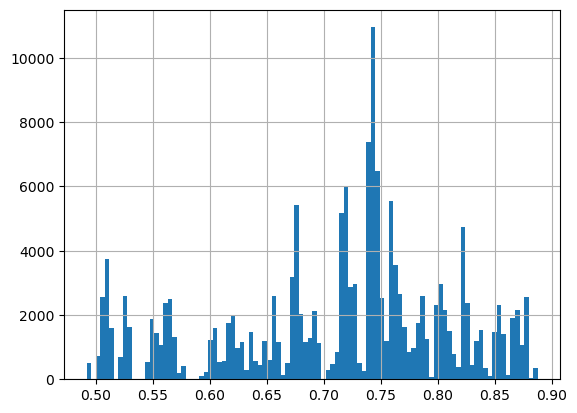

In [18]:
# Notice how the size distribution varies, but most are around 0.75sqkm
hexbinned_cities['area'].hist(bins=100)

In [19]:
# Range of hexbin size within each city. 
# Notice how the differences in area within a single city are minimal.
hexbinned_cities.groupby(['city_id']).agg({'area': [np.min,np.max]})

area      
            min   max
city_id              
10.000    0.764 0.775
79.000    0.851 0.855
143.000   0.867 0.869
183.000   0.647 0.648
288.000   0.746 0.749
321.000   0.723 0.727
323.000   0.819 0.828
359.000   0.703 0.705
367.000   0.706 0.708
392.000   0.739 0.742
400.000   0.776 0.780
458.000   0.745 0.748
467.000   0.840 0.842
473.000   0.681 0.685
528.000   0.868 0.871
530.000   0.711 0.713
621.000   0.770 0.774
634.000   0.738 0.748
651.000   0.715 0.722
741.000   0.564 0.568
770.000   0.756 0.765
816.000   0.549 0.554
849.000   0.781 0.784
855.000   0.713 0.721
857.000   0.637 0.641
931.000   0.634 0.641
945.000   0.736 0.747
1022.000  0.756 0.762
1045.000  0.774 0.775
1074.000  0.651 0.656
1105.000  0.507 0.515
1138.000  0.523 0.526
1303.000  0.741 0.748
1452.000  0.721 0.724
1502.000  0.625 0.629
1510.000  0.659 0.661
1551.000  0.811 0.815
1575.000  0.798 0.802
1656.000  0.685 0.689
1701.000  0.756 0.761
1910.000  0.546 0.555
2046.000  0.654 0.662
2095.000  0.752 0.759
2101.000  0.594 0.596
2125.000  0.598 0.606
2135.000  0.633 0.636
2167.000  0.615 0.619
2253.000  0.661 0.662
2384.000  0.703 0.704
2493.000  0.527 0.530
2749.000  0.601 0.605
2851.000  0.654 0.659
2897.000  0.787 0.790
2927.000  0.695 0.698
2965.000  0.750 0.751
2971.000  0.851 0.853
2973.000  0.551 0.557
3027.000  0.727 0.730
3032.000  0.758 0.760
3034.000  0.845 0.846
3050.000  0.788 0.792
3069.000  0.730 0.732
3186.000  0.768 0.770
3193.000  0.743 0.746
3196.000  0.788 0.789
3209.000  0.787 0.790
3216.000  0.675 0.679
3244.000  0.567 0.572
3255.000  0.568 0.570
3269.000  0.597 0.600
3270.000  0.780 0.782
3274.000  0.818 0.819
3323.000  0.806 0.807
3332.000  0.813 0.814
3339.000  0.635 0.638
3381.000  0.806 0.808
3420.000  0.850 0.852
3444.000  0.784 0.786
3517.000  0.692 0.696
3673.000  0.821 0.826
3675.000  0.688 0.695
3798.000  0.887 0.888
3809.000  0.808 0.811
3868.000  0.779 0.784
3902.000  0.866 0.869
4094.000  0.839 0.840
4172.000  0.838 0.839
4220.000  0.821 0.824
4322.000  0.761 0.762
4335.000  0.796 0.800
4337.000  0.830 0.833
4407.000  0.826 0.828
4408.000  0.833 0.836
4427.000  0.811 0.814
4679.000  0.852 0.852
4808.000  0.809 0.811
5134.000  0.674 0.677
5314.000  0.750 0.755
5528.000  0.781 0.783
5635.000  0.686 0.689
5698.000  0.714 0.720
5737.000  0.757 0.763
5915.000  0.664 0.674
5936.000  0.879 0.879
6008.000  0.879 0.880
6118.000  0.835 0.836
6169.000  0.716 0.720
6845.000  0.671 0.679
6955.000  0.761 0.772
8835.000  0.785 0.789
9872.000  0.796 0.807
10155.000 0.831 0.833
10248.000 0.869 0.871
10479.000 0.626 0.632
10607.000 0.706 0.713
10687.000 0.521 0.531
10715.000 0.875 0.878
11136.000 0.805 0.809
11139.000 0.857 0.860
11498.000 0.836 0.840
11862.000 0.737 0.755
12080.000 0.714 0.732
12109.000 0.492 0.496
12211.000 0.726 0.729
12274.000 0.719 0.722
12389.000 0.501 0.512
12400.000 0.555 0.569
12678.000 0.545 0.549
12696.000 0.645 0.649
12778.000 0.573 0.578
12829.000 0.741 0.751
12858.000 0.606 0.625
12964.000 0.669 0.685
12981.000 0.799 0.802